## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = sum([(1-2*b[i])*(1-2*b[j]) for (i,j) in edges])
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

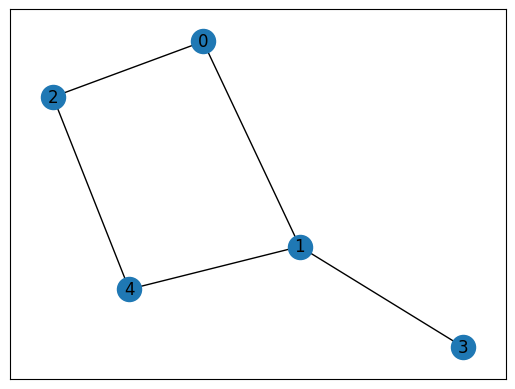

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for i in range(n_qubits):
        layer.apply(RX(theta), i)
    for (k,l) in edges :
        layer.apply(U_ZZ(beta), k, l)

    
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit

    theta = parameters[0::2]
    beta = parameters[1::2]
    #print(theta, beta)
    
    for i in range(n_qubits):
        prog.apply(H, qubits[i])
    
    for j in range(n_layers):
        prog.apply(one_qaoa_layer(n_qubits, edges, theta[j], beta[j]), qubits)
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        b = sample.state.bitstring
        val = sum([(1-2*int(b[i]))*(1-2*int(b[j])) for (i,j) in edges])
        obs += val * sample.probability
    # END TODO
    return obs 
    
# print(evaluate_parameters(5, edges, [0]*10, 1))

In [7]:
import numpy as np
np.random.random(3)

array([0.59650016, 0.38536894, 0.97005919])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

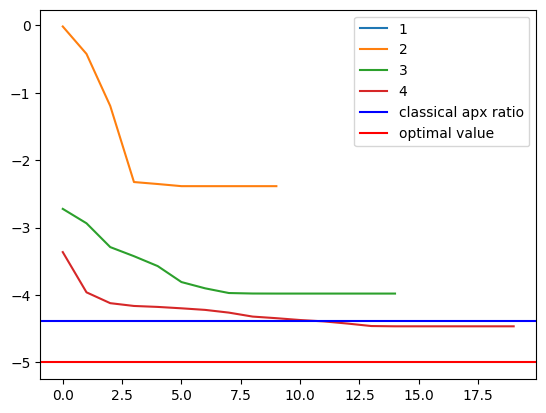

In [12]:
import matplotlib.pylab as plt


for nlayers in range(1,5,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        #print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

Number of layers needed : 4

### Question 6: smart initialization

-0.4393734211423313 -2.044481867030719 -2.328023499990892 -2.4009488024542454 -3.1182346424904734 -3.1327470826039487 -3.1582313768206496 -3.199143842331243 -3.223124916842721 -3.225615930615774 -3.226050702951495 -3.2260693948939663 -3.2260696395567705 -3.226069647230867 -0.4650127126987681 -2.3868713641425354 -2.8111251841683216 -3.4537841330584667 -3.589815037552283 -3.8551260763985455 -4.069524424708615 -4.1334918114658015 -4.187070969984377 -4.281088123293281 -4.337724970314291 -4.37447041331204 -4.391757244056276 -4.413358179547345 -4.429052215056168 -4.439984661547627 -4.446220853901892 -4.4560233247710155 -4.4633918983189425 -4.463774729808495 -4.463830748874207 -4.463831891433726 -4.463832630640522 -4.463832632276263 -4.463832632305382 -0.5505649607774896 -2.5587797547849274 -2.6782721302191583 -3.500668559213835 -3.609968120708961 -3.769649891404711 -3.829094521728114 -3.935861969979233 -4.034642848038836 -4.068129312482914 -4.095604836403158 -4.117654976779942 -4.14707184634

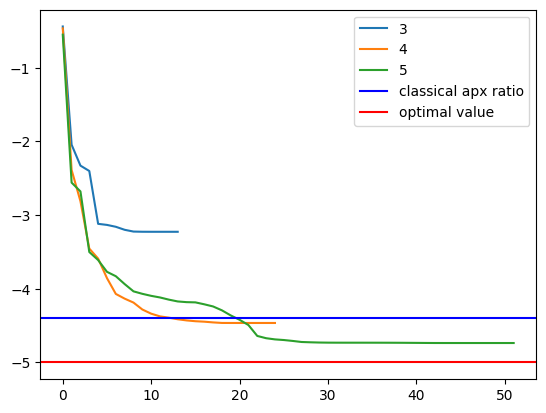

In [15]:
T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    p = nlayers
    for k in range(1,p+1):
        theta = 2*T*(1-k/p)/p
        beta = T*k/p/p
        parameters_init.append(theta)
        parameters_init.append(beta)
    #print(parameters_init)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

Number of layers needed : 4